* Интересная статья про одну из метрик: <a href="https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/">ссылка</a>.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression #updated 2021.11.16
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from tqdm import tqdm

data = pd.read_csv('/datasets/Churn.csv')
display(data.head(5))
display(data.describe())
data.info()
#display(data.isnull().sum())
print(data['Geography'].unique())
print(data['Gender'].unique())

def check_columns(data):
    for column in data.columns:
        print('Уникальные значения столбца', column)
        print(data[column].unique())
check_columns(data)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
['France' 'Spain' 'Germany']
['Female' 'Male']
Уникальные значения столбца RowNumber
[    1     2     3 ...  9998  9999 10000]
Уникальные значения столбца CustomerId
[15634602 15647311 15619304 ... 15584532 15682355 15628319]
Уникальные значения столбца Surname


<div class="alert alert-info">
<b>Вывод: </b> 


1. Датасет содержит 10000 строк, явные пропуски обнаружены только в столбце Tenure - 9 пропущенных значений.
2.

    RowNumber — индекс строки в данных - незначим для аналитики, можем удалить,

    CustomerId — уникальный идентификатор клиента - незначим для аналитики, можем удалить,

    Surname — фамилия - незначим для аналитики, можем удалить,

    CreditScore — кредитный рейтинг - значим, можем посмотреть на распределение, 

    Geography — страна проживания - принимает три значения'France', 'Spain', 'Germany'. Требуется выполнить преобразование One-Hot Encoding.

    Gender — пол - принимаем два значения. Требуется выполнить преобразование One-Hot Encoding.

    Age — возраст.

    Tenure — количество недвижимости у клиента

    Balance — баланс на счёте

    NumOfProducts — количество продуктов банка, используемых клиентом
    
    HasCrCard — наличие кредитной карты
    
    IsActiveMember — активность клиента
    
    EstimatedSalary — предполагаемая зарплата
    
    Exited — Целевой признак, факт ухода клиента
</div>

In [16]:
#1.1 Удалим лишние столбцы
data_new = data.drop(["RowNumber","CustomerId","Surname"], axis = 1)

In [17]:
#1.2 Заполним пропуски. Предполагаю, что если поле не заполнено, то недвижимость отсутствует.
data_new['Tenure']=data_new['Tenure'].fillna(0).astype('int64')

In [18]:
#1.3 Ищем полные дубликаты
print("Число полных дубликатов строк в таблице:", data_new.duplicated().sum())
#Полные дубликаты отсутствуют

Число полных дубликатов строк в таблице: 0


In [19]:
#1.4 Создадим датафрейм, созданный по методу прямого кодирования с защитой от дамми-ловушки.
data_new = pd.get_dummies(data_new, drop_first=True)

In [20]:
display(data_new.head(10))
data_new.info()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0
5,645,44,8,113755.78,2,1,0,149756.71,1,0,1,1
6,822,50,7,0.00,2,1,1,10062.80,0,0,0,1
7,376,29,4,115046.74,4,1,0,119346.88,1,1,0,0
8,501,44,4,142051.07,2,0,1,74940.50,0,0,0,1
9,684,27,2,134603.88,1,1,1,71725.73,0,0,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
CreditScore          10000 non-null int64
Age                  10000 non-null int64
Tenure               10000 non-null int64
Balance              10000 non-null float64
NumOfProducts        10000 non-null int64
HasCrCard            10000 non-null int64
IsActiveMember       10000 non-null int64
EstimatedSalary      10000 non-null float64
Exited               10000 non-null int64
Geography_Germany    10000 non-null uint8
Geography_Spain      10000 non-null uint8
Gender_Male          10000 non-null uint8
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


<div class="alert alert-block alert-success">
В данном случае OHE – наиболее подходящий метод закодировать категориальные колонки.
</div>

## Исследование задачи

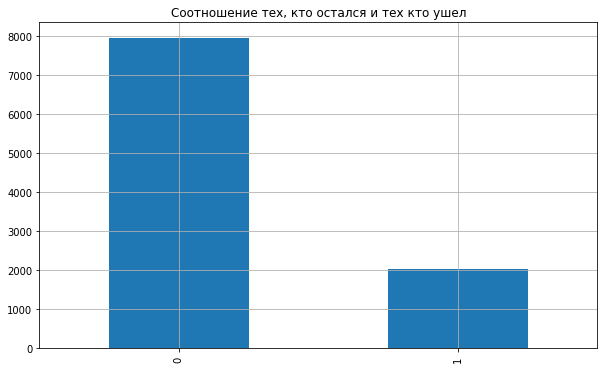

In [21]:
#2 Проанализируем гстограммы значений 
#2.1 оттока и оставшихся клиентов
data_new['Exited'].value_counts().plot(kind='bar',grid=True,
                                       figsize=(10,6),title='Соотношение тех, кто остался и тех кто ушел')

<div class="alert alert-info">
<b>Вывод: </b> 
    
Обнаружили дисбаланс классов. Класс "0" встречается в выборке примерно в 4 раза чаще класса "1".
</div>    

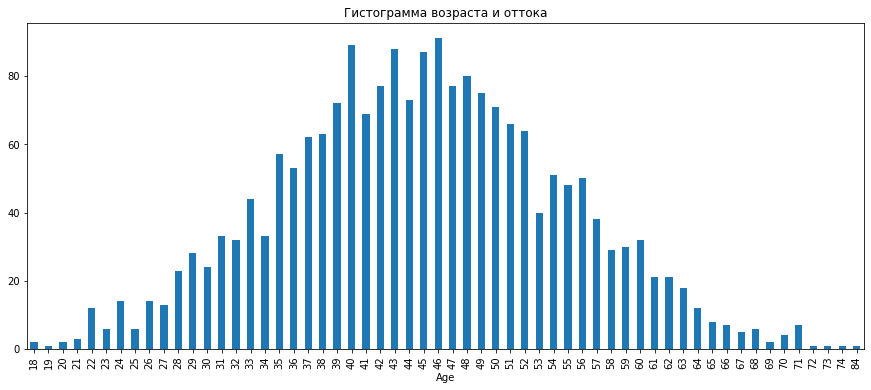

In [22]:
#2.2 По возрасту
data_new.loc[data_new['Exited'] == 1].groupby('Age')['Exited'].count().plot(figsize=(15,6),kind='bar',
                                                                            title='Гистограмма возраста и оттока')
plt.show()

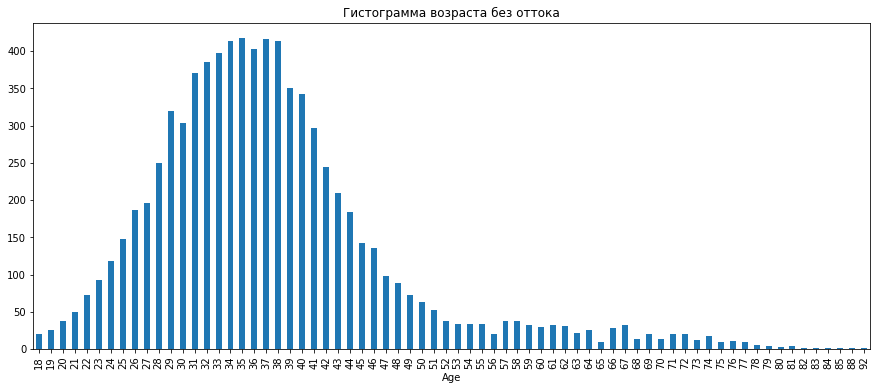

In [23]:
#2.2 По возрасту
data_new.loc[data_new['Exited'] == 0].groupby('Age')['Exited'].count().plot(figsize=(15,6)
                                                                            ,kind='bar',title='Гистограмма возраста без оттока')
plt.show()

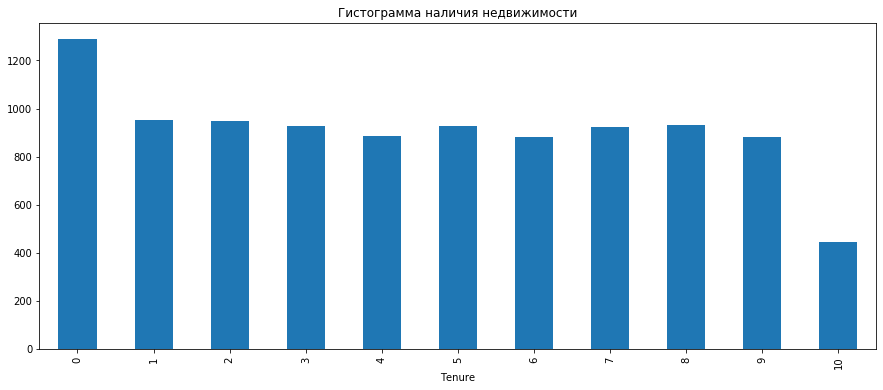

In [24]:
#2.3 Посмотрим как зависит наличие недвижимости без оттока клиентов 
data_new.groupby('Tenure')['Exited'].count().plot(figsize=(15,6),kind='bar',title='Гистограмма наличия недвижимости')
plt.show()

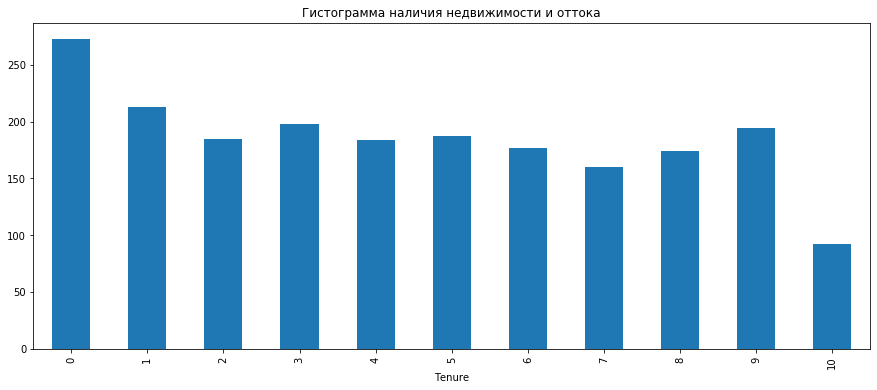

In [25]:
#2.3 Посмотрим как зависит наличие недвижимости и отток клиентов 
data_new.groupby('Tenure')['Exited'].sum().plot(figsize=(15,6),kind='bar',title='Гистограмма наличия недвижимости и оттока')
plt.show()

In [26]:
#2.4 Масшитебируем признаки
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


target=data_new['Exited'] #Целевой признак
features=data_new.drop(['Exited'],axis=1)

# Выделим 60% данных для обучаюшей выборки, и 40% данных для проверки
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify=target)

# Выделим 20% всех данных для тестовой выборки, и оставшиеся 20% данных для валидационной выборки 
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.50, random_state=12345, stratify=target_valid)


numeric=['CreditScore','Age','Balance','EstimatedSalary', 'Tenure', 'NumOfProducts']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

display(features_train.head(10))
features_train.info()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
2837,-1.040434,0.953312,0.467449,0.774657,-0.914708,0,1,-0.119110,1,0,0
9925,0.454006,-0.095244,-1.461501,1.910540,-0.914708,1,1,-0.258658,0,0,0
8746,0.103585,-0.476537,1.110432,0.481608,0.820981,0,1,1.422836,0,0,1
660,-0.184996,0.190726,-1.461501,0.088439,-0.914708,1,1,-1.160427,1,0,0
3610,-0.720933,1.620574,-1.140009,0.879129,-0.914708,1,0,0.113236,0,0,0
2934,-0.195303,-0.571860,0.788940,-1.219673,-0.914708,1,1,-0.736302,0,0,1
688,-0.257141,1.143958,0.788940,0.957840,-0.914708,1,0,-1.069604,0,0,0
3640,-0.123157,0.000079,-1.461501,0.737465,0.820981,1,1,-0.093794,1,0,0
8443,-0.318980,-1.525092,0.145957,0.900806,-0.914708,1,1,0.756262,1,0,1
3020,-0.813691,-0.095244,0.467449,0.492906,0.820981,0,0,-1.067944,0,0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 2837 to 700
Data columns (total 11 columns):
CreditScore          6000 non-null float64
Age                  6000 non-null float64
Tenure               6000 non-null float64
Balance              6000 non-null float64
NumOfProducts        6000 non-null float64
HasCrCard            6000 non-null int64
IsActiveMember       6000 non-null int64
EstimatedSalary      6000 non-null float64
Geography_Germany    6000 non-null uint8
Geography_Spain      6000 non-null uint8
Gender_Male          6000 non-null uint8
dtypes: float64(6), int64(2), uint8(3)
memory usage: 439.5 KB


<div class="alert alert-block alert-success">
Scaler был обучен только на тренировочной части данных. Это уменьшает переобучение.
</div>

In [28]:
#2.5 Логистическая регрессия без балансировки классов
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train) #updated 2021.11.16
predicted_valid = model.predict(features_valid)

print("Для модели Логистической регрессии:")  
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print("F1:", f1_score(target_valid, predicted_valid))
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)            # На вход функция roc_auc_score() принимает не предсказания, а вероятности класса «1»      
print("AUC-ROC:",auc_roc)
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))


Для модели Логистической регрессии:
Precision 0.6086956521739131
Recall 0.20588235294117646
F1: 0.3076923076923077
AUC-ROC: 0.787586831214898
Точность попадания по классам 0.811


In [32]:
#2.6 Стучайный лес без балансировки классов
best_model = None
best_f1 = 0
best_est = 1
best_depth = 1
for est in tqdm(range(20, 120, 20)):
    for depth in range (5, 25, 5):
        model = RandomForestClassifier(random_state=12345, 
                                       n_estimators=est, max_depth=depth)  # Обучим модель с заданным количеством деревьев
        model.fit(features_train, target_train)                    # Обучим модель на новых данных
        predicted_valid = model.predict(features_valid)                    # Найдем предсказания на валидационной выборк
        current_f1 = f1_score(target_valid, predicted_valid)
        if best_f1 < current_f1:
            best_f1 = current_f1                                 # лучшее значение метрики F1 на валидационных данных
            best_est = est                                       # лучшее значение количества деревьев в лесу
            best_depth_ = depth                                  # лучшее значение максимальной глубины дерева
            best_model = model

print("Для модели Случайного леса")
print("   с количеством деревьев n_estimators=", best_est,"и глубиной=", best_depth)        
predicted_valid = best_model.predict(features_valid) 
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid)) 
probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)            # На вход функция roc_auc_score() принимает не предсказания, а вероятности класса «1»
print("AUC-ROC:", auc_roc)
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))

100%|██████████| 5/5 [00:10<00:00,  2.01s/it]

Для модели Случайного леса
   с количеством деревьев n_estimators= 40 и глубиной= 1
Precision 0.7666666666666667
Recall 0.5073529411764706
F1 0.6106194690265487
AUC-ROC: 0.8566592151936152
Точность попадания по классам 0.868


F1-мера ниже целевого значения (0.61 > 0.59)

## Борьба с дисбалансом

In [33]:
#3.1 Увеличим количество клиентов оттока в 4 раза(target==1)
from sklearn.utils import shuffle

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [34]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    # Добавим перемешивание функцией shuffle()
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

<div class="alert alert-info">
<b>Вывод: </b> 
    
1. Сбалансировали классы путём увеличения числа (техникой upsampling).
2. Сбалансировали классы путём уменьшения числа (техникой downsampling).
</div>

<div class="alert alert-block alert-success">
Парамтер repeat и fraction были выбраны таким образом, чтобы классы стали сбалансированными.
</div>

## Тестирование модели

In [35]:
#4.1 Логистическая регрессия

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("Для модели Логистической регрессии при балансировке методом upsampling:")  
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print("F1:", f1_score(target_valid, predicted_valid))
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)            # На вход функция roc_auc_score() принимает не предсказания, а вероятности класса «1»      
print("AUC-ROC:",auc_roc)
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))

Для модели Логистической регрессии при балансировке методом upsampling:
Precision 0.40562248995983935
Recall 0.7426470588235294
F1: 0.5246753246753246
AUC-ROC: 0.7938220514336388
Точность попадания по классам 0.7255


F1-мера ниже целевого значения (0.52 < 0.59)

In [36]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("Для модели Логистической регрессии при балансировке методом downsampling:")  
print("F1:", f1_score(target_valid, predicted_valid))
print("MAE:", mean_absolute_error(target_valid, predicted_valid)) 
print("Коэффициент детерминации, или метрика R2", r2_score(target_valid, predicted_valid))
print("Accuracy", model.score(features_valid, target_valid)) 
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)            # На вход функция roc_auc_score() принимает не предсказания, а вероятности класса «1»      
print("AUC-ROC:",auc_roc)
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))

Для модели Логистической регрессии при балансировке методом downsampling:
F1: 0.5250431778929188
MAE: 0.275
Коэффициент детерминации, или метрика R2 -0.6935166026209478
Accuracy 0.725
AUC-ROC: 0.792741279929057
Точность попадания по классам 0.725
Precision 0.4053333333333333
Recall 0.7450980392156863


In [38]:
#4.2 Случайный лес

best_model_up = None
best_f1_up = 0
best_est_up = 1
best_depth_up = 5
for est in tqdm(range(20, 120, 20)):
    for depth in range (5, 25, 5):
        model = RandomForestClassifier(random_state=12345, 
                                       n_estimators=est, max_depth=depth)  # Обучим модель с заданным количеством деревьев
        model.fit(features_upsampled, target_upsampled)                    # Обучим модель на новых данных
        predicted_valid = model.predict(features_valid)                    # Найдем предсказания на валидационной выборк
        current_f1 = f1_score(target_valid, predicted_valid)
        if best_f1_up < current_f1:
            best_f1_up = current_f1                                 # лучшее значение метрики F1 на валидационных данных
            best_est_up = est                                       # лучшее значение количества деревьев в лесу
            best_depth_up = depth                                  # лучшее значение максимальной глубины дерева updated 2021.11.16
            best_model_up = model

print("Для модели Случайного леса при балансировке методом upsampling")
print("   с количеством деревьев n_estimators=", best_est_up,"и глубиной=", best_depth_up)        
predicted_valid = best_model_up.predict(features_valid) 
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
probabilities_valid = best_model_up.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)            # На вход функция roc_auc_score() принимает не предсказания, а вероятности класса «1»
print("AUC-ROC:", auc_roc)
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))


100%|██████████| 5/5 [00:14<00:00,  2.84s/it]

Для модели Случайного леса при балансировке методом upsampling
   с количеством деревьев n_estimators= 60 и глубиной= 10
Precision 0.5774647887323944
Recall 0.7034313725490197
F1 0.6342541436464089
AUC-ROC: 0.8671759532958911
Точность попадания по классам 0.8345


F1-мера выше целевого значения (0.63 > 0.59)

In [40]:

best_model_down = None
best_f1_down = 0
best_est_down = 1
best_depth_down = 5
for est in tqdm(range(20, 120, 20)):
    for depth in range (5, 25, 5):
        model = RandomForestClassifier(random_state=12345, 
                                       n_estimators=est, max_depth=depth)  # Обучим модель с заданным количеством деревьев
        model.fit(features_downsampled, target_downsampled)                    # Обучим модель на новых данных
        predicted_valid = model.predict(features_valid)                    # Найдем предсказания на валидационной выборк
        current_f1 = f1_score(target_valid, predicted_valid)
        if best_f1_down < current_f1:
            best_f1_down = current_f1                                 # лучшее значение метрики F1 на валидационных данных
            best_est_down = est                                       # лучшее значение количества деревьев в лесу
            best_depth_down = depth                                  # лучшее значение максимальной глубины дерева
            best_model_down = model

print("Для модели Случайного леса при балансировке методом downsampling")
print("   с количеством деревьев n_estimators=", best_est_down,"и глубиной=", best_depth_down)        
predicted_valid = best_model_down.predict(features_valid) 
print('Precision', precision_score(target_valid, predicted_valid))
print('Recall', recall_score(target_valid, predicted_valid))
print('F1', f1_score(target_valid, predicted_valid))
probabilities_valid = best_model_down.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)            # На вход функция roc_auc_score() принимает не предсказания, а вероятности класса «1»
print("AUC-ROC:", auc_roc)
print('Точность попадания по классам', accuracy_score(target_valid, predicted_valid))

100%|██████████| 5/5 [00:06<00:00,  1.20s/it]

Для модели Случайного леса при балансировке методом downsampling
   с количеством деревьев n_estimators= 20 и глубиной= 5
Precision 0.5111111111111111
Recall 0.7892156862745098
F1 0.6204238921001928
AUC-ROC: 0.8596421137550497
Точность попадания по классам 0.803


F1-мера ниже целевого значения (0.62  >  0.59)

In [42]:
# Найдем предсказания на тестовой выборке лучшей модели Случайного леса (модели с увеличением выборки upsampling)
predicted_test = best_model_up.predict(features_test)       
test_f1 = f1_score(target_test, predicted_test)
probabilities_test = best_model_up.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc_test = roc_auc_score(target_test, probabilities_one_test)             
print("Проверка на тестовой выборке модели Случайного леса с увеличением выборки (upsampling):")        
print("F1-мера:", test_f1)
print(" Метрика AUC-ROC",auc_roc_test)

# Найдем предсказания на тестовой выборке лучшей модели Случайного леса (модели с увеличением выборки downsampling)
predicted_test = best_model_down.predict(features_test)       
test_f1 = f1_score(target_test, predicted_test)
probabilities_test = best_model_down.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc_test = roc_auc_score(target_test, probabilities_one_test)             
print("Проверка на тестовой выборке модели Случайного леса с уменьшением выборки (downsampling):")        
print("F1-мера:", test_f1)
print(" Метрика AUC-ROC",auc_roc_test)

Проверка на тестовой выборке модели Случайного леса с увеличением выборки (upsampling):
F1-мера: 0.6035634743875279
 Метрика AUC-ROC 0.8515726820811567
Проверка на тестовой выборке модели Случайного леса с уменьшением выборки (downsampling):
F1-мера: 0.5867689357622244
 Метрика AUC-ROC 0.8408763154525867


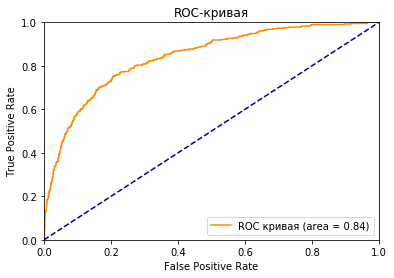

In [53]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

#Визуализация ROC-кривой
#FPR — доля ложноположительных примеров
fpr, tpr, treshold = roc_curve(target_test, probabilities_one_test)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % auc_roc_test)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

<div class="alert alert-info">
<b>Вывод: </b> 
    
В ходе исследования:

1. загрузили и изучили исходные данные; выполнили их предварительную обработку
2. разделили данные на обучающую и тестовую выборки
3. выявили дисбаланс классов "0" и "1"
4. построили модели случайного леса и логистической регрессии без учёта дисбаланса
5. оценили качество моделей по метрикам F1-мера и AUC-ROC
6. сбалансировали классы методами увеличения выборки (upsampling) и уменьшения выборки (downsampling)
7. получили улучшенные модели с более высокими значениями метрик F1-мера и AUC-ROC. Метрика F1-мера превысила целевое значение 0.59 при балансировании классов использовали методом увеличения числа строк (upsampling).
</div>

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*